
[![Udacity - Self-Driving Car NanoDegree](https://s3.amazonaws.com/udacity-sdc/github/shield-carnd.svg)](http://www.udacity.com/drive)
## Vehicle Detection & Tracking Pipeline

In this project, your goal is to write a software pipeline to detect vehicles in a video (start with the test_video.mp4 and later implement on full project_video.mp4), but the main output or product we want you to create is a detailed writeup of the project.  Check out the [writeup template](https://github.com/udacity/CarND-Vehicle-Detection/blob/master/writeup_template.md) for this project and use it as a starting point for creating your own writeup.  

The Project
---

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

Here are links to the labeled data for [vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and [non-vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip) examples to train your classifier.  These example images come from a combination of the [GTI vehicle image database](http://www.gti.ssr.upm.es/data/Vehicle_database.html), the [KITTI vision benchmark suite](http://www.cvlibs.net/datasets/kitti/), and examples extracted from the project video itself.   You are welcome and encouraged to take advantage of the recently released [Udacity labeled dataset](https://github.com/udacity/self-driving-car/tree/master/annotations) to augment your training data.  

Some example images for testing your pipeline on single frames are located in the `test_images` folder.  To help the reviewer examine your work, please save examples of the output from each stage of your pipeline in the folder called `ouput_images`, and include them in your writeup for the project by describing what each image shows.    The video called `project_video.mp4` is the video your pipeline should work well on.  

### Dataset - Load Data and Extract Features

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from PIL import Image
import time
import os
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [51]:
# Udacity Dataset Parameters
LABELS_CSV = 'FILL_LATER.csv'

# Image Processing
DEFAULT_LENGTH, DEFAULT_WIDTH, DEFAULT_DEPTH = (64, 64, 3)
DEFAULT_RESOLUTION = (DEFAULT_LENGTH, DEFAULT_WIDTH, DEFAULT_DEPTH) if DEFAULT_DEPTH > 1 else (DEFAULT_LENGTH, DEFAULT_WIDTH)
TRAINING_DATASET_DIRECTORY = 'training_set/'
PIPELINE_SETUP_DIRECTORY = 'pipeline_setup_images/'
WORKING_DIRECTORY = 'data/'
NON_VEHICLES_TOKEN = 'non-vehicles'

# Feature Extraction Parameters
BIN_SPATIAL_SIZE = (32, 32)
HIST_NBINS = 128
HIST_BINS_RANGE = (0, 256)
COLOR_SPACE = 'RGB'
dataset_path = "{}{}{}{}".format(WORKING_DIRECTORY, PIPELINE_SETUP_DIRECTORY,'**/', '*.png')

In [80]:
# Define a function to scale .PNG and JPEG Files both to 0 to 1 
def normalize_pixels(img):
    max_pixel_value = np.amax(img.ravel())
    if max_pixel_value > 1.0:
        img = np.copy(np.multiply(img, 1.0 / 255.0)).astype(np.float64) 
    return img

# Define a function to scale .PNG and JPEG Files both to 0 to 1 
def denormalize_pixels(img):
    max_pixel_value = np.amax(img.ravel())
    if max_pixel_value <= 1.0:
        img = np.copy(np.multiply(img, 255.0)).astype(np.float64) 
    return img

# PNG Files sometimes have an alpha channel (RGBA), convert to RGB in such cases
def rgba_to_rgb(filepaths):
    for current_img in filepaths:
        if os.path.exists(current_img):
            img = Image.open(current_img)
            if img.mode == 'RGBA':
                img = img.convert(COLOR_SPACE)
                img.save(current_img)
            img.close()

In [81]:
# Define a function to compute binned color features  
def bin_spatial(img, size=BIN_SPATIAL_SIZE):
    denormalized_img = denormalize_pixels(img)
    # Scale down and ravel image  
    features = cv2.resize(denormalized_img, size).ravel() 
    return features

In [82]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=HIST_NBINS, bins_range=HIST_BINS_RANGE):
    denormalized_img = denormalize_pixels(img)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(denormalized_img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(denormalized_img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(denormalized_img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


In [83]:
# Define a function to extract features from a list of images
def extract_features(imgs, cspace=COLOR_SPACE, spatial_size=BIN_SPATIAL_SIZE,
                        hist_bins=HIST_NBINS, hist_range=HIST_BINS_RANGE):
    # Create a list to append feature vectors
    features = []
    for file in imgs:
        image = mpimg.imread(file)
        #Denormalize Pixels read in from mpimg
        denormalized_img = denormalize_pixels(image)

        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)
        
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features

In [84]:
# Load Image Paths
images = glob.glob(dataset_path, recursive=True)
print('Found',len(images),'images in directory:', dataset_path)

#Convert RGBA to RGB for PNG files
rgba_to_rgb(images)

cars = []
notcars = []
for image in images:
    if NON_VEHICLES_TOKEN in image:
        notcars.append(image)
    else:
        cars.append(image)
assert len(images) == len(cars) + len(notcars), 'The subarrays have not split the dataset correctly.'

Found 221 images in directory: data/pipeline_setup_images/**/*.png


Feature Vector size for Cars: 3456
Using Spatial Binning of: 32 and 128 histogram bins


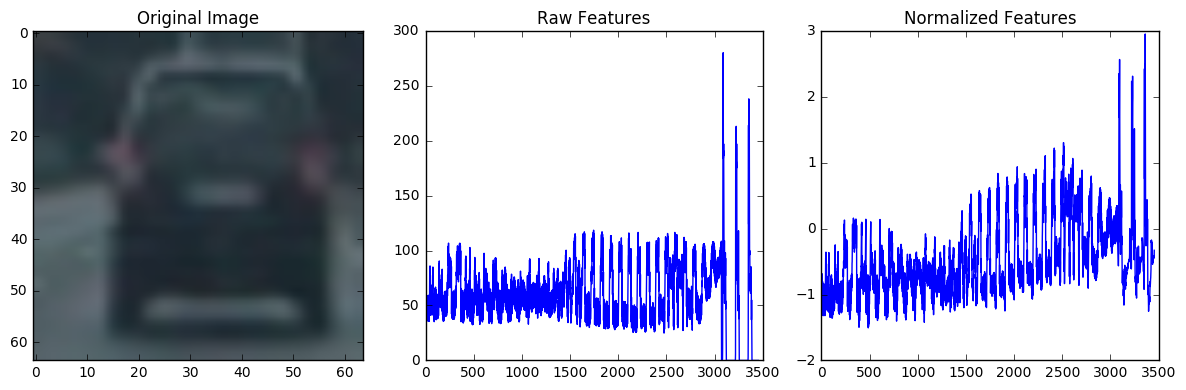

In [85]:
# Start Pipeline - Combine and Normalilze Features
car_features = extract_features(cars)
notcar_features = extract_features(notcars)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)  

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)
car_ind = np.random.randint(0, len(cars))
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(cars[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()

print('Feature Vector size for Cars:', len(car_features[car_ind]))
print('Using Spatial Binning of:',BIN_SPATIAL_SIZE[0],
    'and', HIST_NBINS,'histogram bins')
fig

In [86]:
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

In [87]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)
print('Feature vector length:', len(X_train[0]))

Feature vector length: 3456
